In [95]:
%matplotlib inline
import os, sys, time
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack


import matplotlib.pyplot as plt

import yaml
import cPickle as pickle

In [99]:
data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'
pickle_column_names_file = data_path + 'cat_col_names.pkl'

In [101]:
'''
This section loads a fraction of categorical data and save the columns
names into a pickle file named by 'pickle_column_names_file'.
So that the following categorical data loading can directly use explicitly types
'''

def create_categorical_column_name_pickle(train_cat_file, pickle_column_names_file):
    
    tmp_train_cat = pd.read_csv(data_path + train_cat_file, index_col='Id', nrows=1000)

    #for col, dtype in zip(tmp_train_cat.columns, tmp_train_cat.dtypes):
    #    print len(train_cat[col].unique()), dtype

    ## save the column names to pickle file
    col_names = tmp_train_cat.columns.tolist()
    with open(pickle_column_names_file, 'wb') as pickle_file:
        pickle.dump(col_names, pickle_file)

In [24]:
start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'

## number of bins to separate data by start_time
bin_num = 15

In [27]:
start_time = time.time()
## load the labels and start_time column for train and test data
train_labels = pd.read_csv(data_path + train_num_file, index_col='Id', usecols=['Id', dep_var_name])
train_date_start_columm = pd.read_csv(data_path + train_date_file, index_col='Id', usecols=['Id', start_time_column_name])
test_date_start_columm = pd.read_csv(data_path + test_date_file, index_col='Id', usecols=['Id', start_time_column_name])
end_time = time.time()
print 'data loading takes ', round((end_time - start_time), 1), ' seconds.'

data loading takes  57.462346077  seconds.


In [36]:
## join the start_time with labels, then drop the NaN in start_time
labeled_start_time = pd.merge(train_labels, train_date_start_columm, how='left', left_index=True, right_index=True)
print labeled_start_time.shape
## this labeled_start_time dataFrame doesn't contain the NaN
## can be directly used for calculating the mquantiles
labeled_start_time = labeled_start_time[~labeled_start_time[start_time_column_name].isnull()]

(1183747, 2)


In [58]:
'''
section to subset the data by start_time
'''
from scipy.stats.mstats import mquantiles

prob_list = [1.*i/bin_num for i in range(1, bin_num)]
quantile_values = mquantiles(labeled_start_time[start_time_column_name], prob=prob_list)

bins = [labeled_start_time[start_time_column_name].min()]
bins.extend(quantile_values)
bins.append(labeled_start_time[start_time_column_name].max())
bin_names = [str(i) for i in range(len(bins)-1)]

In [155]:
## cut the entire dataframe into different time_windows by start_time
tmp_train = train_date_start_columm.copy()
tmp_test = test_date_start_columm.copy()

tmp_train['time_window_num'] = pd.cut(tmp_train[start_time_column_name], bins, labels=bin_names)
tmp_test['time_window_num'] = pd.cut(tmp_test[start_time_column_name], bins, labels=bin_names)
## create a row number column, start index is 1
tmp_train['row_num'] = range(1, (tmp_train.shape[0] + 1))
tmp_test['row_num'] = range(1, (tmp_test.shape[0] + 1))

In [156]:
tmp_train.head()

,L0_S0_D1,time_window_num,row_num
Id,,,
4,82.24,0,1
6,NaN,NaN,2
7,1618.70,14,3
9,1149.20,9,4
11,602.64,5,5


In [157]:
tmp_test.head()

,L0_S0_D1,time_window_num,row_num
Id,,,
1,NaN,NaN,1
2,NaN,NaN,2
3,NaN,NaN,3
5,255.45,2,4
8,NaN,NaN,5


In [151]:
'''
## sample for create the skipped row number list for row selection
select_window_num = '0'
none_selected_window_num = bin_names
none_selected_window_num.append(np.NaN)
none_selected_window_num.remove(select_window_num)

skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()

print bin_names, len(bins)
'''

"\n## sample for create the skipped row number list for row selection\nselect_window_num = '0'\nnone_selected_window_num = bin_names\nnone_selected_window_num.append(np.NaN)\nnone_selected_window_num.remove(select_window_num)\n\nskipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()\nskipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()\n\nprint bin_names, len(bins)\n"

In [158]:
def process_date_data(train_date, test_date, start_time_column_name):
    print 'raw date data dimension: ', train_date.shape, test_date.shape
    train_date['start_time'] = train_date[start_time_column_name]
    test_date['start_time'] = test_date[start_time_column_name]
    single_value_column_names = []

    for column in train_date.columns:
        if column != 'start_time':
            train_date[column] = train_date[column] - train_date['start_time']
            test_date[column] = test_date[column] - test_date['start_time']
        if len(train_date[column].unique()) == 1:
            single_value_column_names.append(column)
            
    ## drop single-valued columns        
    train_date.drop(single_value_column_names, axis=1, inplace=True)
    test_date.drop(single_value_column_names, axis=1, inplace=True)
    print 'processed date data dimension: ', train_date.shape, test_date.shape
    

    
def remove_single_value_categorical_columns(train, test):
    print 'raw categorical data dimension: ', train.shape, test.shape
    single_value_column_names = []
    for col in train.columns:
        if len(train[col].unique()) == 1:
            single_value_column_names.append(col)
    
    train.drop(single_value_column_names, axis=1, inplace=True)
    test.drop(single_value_column_names, axis=1, inplace=True)
    print 'processed categorical data dimension: ', train.shape, test.shape



def encode_categorical_data(train, test, fill_missing = False):
    '''
    encoding is an extemely slow process
    So only use the training data to trian the encoder
    '''
    le = LabelEncoder()
    
    if fill_missing:
        train = train.fillna(value='missing')
        test = test.fillna(value='missing')
    
    ## idealy combine the train and test
    #combined = pd.concat([train, test], axis=0)
    counter = 0
    start_time = time.time()
    for col, dtype in zip(train.columns, train.dtypes):
        if dtype == 'object':
            le.fit(pd.concat([train[col], test[col]], axis=0))
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
                              
        counter += 1
        if counter % 20 == 0:
            print '{} out of {} is process...'.format(str(counter), str(train.shape[1]))
                              
    end_time = time.time()
    print 'encoding process takes ', round((end_time - start_time)), 'seconds'
    
    return train, test
    

def load_data_by_index(skipped_train_row_num, skipped_test_row_num, train_data_file, test_data_file):

    start_time = time.time()

    ## section to load column names for categorical data
    if not os.path.isfile(pickle_column_names_file):
        print 'create new column name pickle file ...'
        create_categorical_column_name_pickle(train_cat_file, pickle_column_names_file)
    
    with open(pickle_column_names_file, 'rb') as pickle_file:
        cat_column_names = pickle.load(pickle_file)
    
    column_types = [np.object] * len(cat_column_names)
    column_types_dict = dict(zip(cat_column_names, column_types))
    ######

    train_date = pd.read_csv(data_path + train_date_file, index_col='Id', skiprows=skipped_train_row_num)
    train_num = pd.read_csv(data_path + train_num_file, index_col='Id', skiprows=skipped_train_row_num)
    train_cat = pd.read_csv(data_path + train_cat_file, index_col='Id', skiprows=skipped_train_row_num, dtype=column_types_dict)

    test_date = pd.read_csv(data_path + test_date_file, index_col='Id', skiprows=skipped_test_row_num)
    test_num = pd.read_csv(data_path + test_num_file, index_col='Id', skiprows=skipped_test_row_num)
    test_cat = pd.read_csv(data_path + test_cat_file, index_col='Id', skiprows=skipped_test_row_num, dtype=column_types_dict)

    end_time = time.time()
    print 'data loading takes ', round((end_time - start_time), 2), 'seconds'
    
    ## process the date data
    process_date_data(train_date, test_date, start_time_column_name)
    print 'finish processing date data ...'
    
    ## process categorical data
    remove_single_value_categorical_columns(train_cat, test_cat)
    encode_categorical_data(train_cat, test_cat)
    print 'finish processing categorical data ...'

    ## combine the data and save into csv files
    combined_train = pd.concat([train_cat, train_num, train_date], axis=1)
    combined_test = pd.concat([test_cat, test_num, test_date], axis=1)
    
    combined_train.to_csv(train_data_file)
    combined_test.to_csv(test_data_file)

In [ ]:
## dict for the yaml file
subset_data_dict = {}

## for the NaN start_time rows
print 'for bin: NaN', 
none_selected_window_num = bin_names[:]
skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
selected_bin_name = 'NaN'
subset_data_dict[selected_bin_name] = {}
subset_data_dict[selected_bin_name]['start_time'] = 'NaN'
subset_data_dict[selected_bin_name]['end_time'] = 'NaN'
#print len(skipped_test_row_num), len(skipped_train_row_num), skipped_test_row_num[:10], skipped_train_row_num[:10]

train_data_file = 'processed_totBins_' + str(len(bin_names)+1) + '_bin_' + selected_bin_name + '_train.csv'
test_data_file = 'processed_totBins_' + str(len(bin_names)+1) + '_bin_' + selected_bin_name + '_test.csv'
load_data_by_index(skipped_train_row_num, skipped_test_row_num, train_data_file, test_data_file)
subset_data_dict[selected_bin_name]['train_file'] = train_data_file
subset_data_dict[selected_bin_name]['test_file'] = test_data_file

for selected_bin_name, i in zip(bin_names, range(len(bin_names))):
    print 'for bin:', selected_bin_name
    subset_data_dict[selected_bin_name] = {}
    none_selected_window_num = bin_names[:]
    none_selected_window_num.append(np.NaN)
    none_selected_window_num.remove(selected_bin_name)
    subset_data_dict[selected_bin_name]['start_time'] = round(float(bins[i]), 2)
    subset_data_dict[selected_bin_name]['end_time'] = round(float(bins[i+1]), 2)

    skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
    skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
    print len(skipped_test_row_num), len(skipped_train_row_num), skipped_test_row_num[:10], skipped_train_row_num[:10]
    
    train_data_file = 'processed_totBins_' + str(len(bin_names)+1) + '_bin_' + selected_bin_name + '_train.csv'
    test_data_file = 'processed_totBins_' + str(len(bin_names)+1) + '_bin_' + selected_bin_name + '_test.csv'
    load_data_by_index(skipped_train_row_num, skipped_test_row_num, train_data_file, test_data_file)
    subset_data_dict[selected_bin_name]['train_file'] = train_data_file
    subset_data_dict[selected_bin_name]['test_file'] = test_data_file


print subset_data_dict
with open('subsest_data_dict.yml', 'w') as outfile:
    yaml.dump(subset_data_dict, outfile, default_flow_style=False)


data loading takes  555.32 seconds
raw date data dimension:  (509886, 1156) (509245, 1156)
processed date data dimension:  (509886, 173) (509245, 173)
finish processing date data ...
raw categorical data dimension:  (509886, 2140) (509245, 2140)
processed categorical data dimension:  (509886, 1792) (509245, 1792)
20 out of 1792 is process...
40 out of 1792 is process...
60 out of 1792 is process...
80 out of 1792 is process...
100 out of 1792 is process...
120 out of 1792 is process...
140 out of 1792 is process...
160 out of 1792 is process...
180 out of 1792 is process...
200 out of 1792 is process...
220 out of 1792 is process...
240 out of 1792 is process...
260 out of 1792 is process...
280 out of 1792 is process...
300 out of 1792 is process...
320 out of 1792 is process...
340 out of 1792 is process...
360 out of 1792 is process...
380 out of 1792 is process...


### R&D steps for the data

In [63]:
## create the skipped row number list for row selection
select_window_num = np.NaN
none_selected_window_num = bin_names
none_selected_window_num.append(np.NaN)
none_selected_window_num.remove(select_window_num)

skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()


In [65]:
print len(skipped_test_row_num), len(skipped_train_row_num), skipped_test_row_num[:10], skipped_train_row_num[:10]

674503 673861 [4, 6, 7, 8, 11, 12, 13, 14, 15, 16] [1, 3, 4, 5, 6, 9, 11, 12, 13, 14]


In [ ]:
test_index = tmp[tmp['time_window_num']=='0'].index.tolist()
print 'selected row number: ', tmp.shape[0] - len(skipped_row_num)

In [140]:
load_data_by_index(skipped_train_row_num, skipped_test_row_num, 'tmp_train.csv', 'tmp_test.csv')

data loading takes  91.98 seconds
raw date data dimension:  (44909, 1156) (44980, 1156)
processed date data dimension:  (44909, 495) (44980, 495)
finish processing date data ...
raw categorical data dimension:  (44909, 2140) (44980, 2140)
processed categorical data dimension:  (44909, 436) (44980, 436)
20 out of 436 is process...
40 out of 436 is process...
60 out of 436 is process...
80 out of 436 is process...
100 out of 436 is process...
120 out of 436 is process...
140 out of 436 is process...
160 out of 436 is process...
180 out of 436 is process...
200 out of 436 is process...
220 out of 436 is process...
240 out of 436 is process...
260 out of 436 is process...
280 out of 436 is process...
300 out of 436 is process...
320 out of 436 is process...
340 out of 436 is process...
360 out of 436 is process...
380 out of 436 is process...
400 out of 436 is process...
420 out of 436 is process...
encoding process takes  173.0 seconds
finish processing categorical data ...


In [139]:
def process_date_data(train_date, test_date, start_time_column_name):
    print 'raw date data dimension: ', train_date.shape, test_date.shape
    train_date['start_time'] = train_date[start_time_column_name]
    test_date['start_time'] = test_date[start_time_column_name]
    single_value_column_names = []

    for column in train_date.columns:
        if column != 'start_time':
            train_date[column] = train_date[column] - train_date['start_time']
            test_date[column] = test_date[column] - test_date['start_time']
        if len(train_date[column].unique()) == 1:
            single_value_column_names.append(column)
            
    ## drop single-valued columns        
    train_date.drop(single_value_column_names, axis=1, inplace=True)
    test_date.drop(single_value_column_names, axis=1, inplace=True)
    print 'processed date data dimension: ', train_date.shape, test_date.shape
    

    
def remove_single_value_categorical_columns(train, test):
    print 'raw categorical data dimension: ', train.shape, test.shape
    single_value_column_names = []
    for col in train.columns:
        if len(train[col].unique()) == 1:
            single_value_column_names.append(col)
    
    train.drop(single_value_column_names, axis=1, inplace=True)
    test.drop(single_value_column_names, axis=1, inplace=True)
    print 'processed categorical data dimension: ', train.shape, test.shape



def encode_categorical_data(train, test, fill_missing = False):
    '''
    encoding is an extemely slow process
    So only use the training data to trian the encoder
    '''
    le = LabelEncoder()
    
    if fill_missing:
        train = train.fillna(value='missing')
        test = test.fillna(value='missing')
    
    ## idealy combine the train and test
    #combined = pd.concat([train, test], axis=0)
    counter = 0
    start_time = time.time()
    for col, dtype in zip(train.columns, train.dtypes):
        if dtype == 'object':
            le.fit(pd.concat([train[col], test[col]], axis=0))
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
                              
        counter += 1
        if counter % 20 == 0:
            print '{} out of {} is process...'.format(str(counter), str(train.shape[1]))
                              
    end_time = time.time()
    print 'encoding process takes ', round((end_time - start_time)), 'seconds'
    
    

def load_data_by_index(skipped_train_row_num, skipped_test_row_num, train_data_file, test_data_file):

    start_time = time.time()

    ## section to load column names for categorical data
    if not os.path.isfile(pickle_column_names_file):
        print 'create new column name pickle file ...'
        create_categorical_column_name_pickle(train_cat_file, pickle_column_names_file)
    
    with open(pickle_column_names_file, 'rb') as pickle_file:
        cat_column_names = pickle.load(pickle_file)
    
    column_types = [np.object] * len(cat_column_names)
    column_types_dict = dict(zip(cat_column_names, column_types))
    ######

    train_date = pd.read_csv(data_path + train_date_file, index_col='Id', skiprows=skipped_train_row_num)
    train_num = pd.read_csv(data_path + train_num_file, index_col='Id', skiprows=skipped_train_row_num)
    train_cat = pd.read_csv(data_path + train_cat_file, index_col='Id', skiprows=skipped_train_row_num, dtype=column_types_dict)

    test_date = pd.read_csv(data_path + test_date_file, index_col='Id', skiprows=skipped_test_row_num)
    test_num = pd.read_csv(data_path + test_num_file, index_col='Id', skiprows=skipped_test_row_num)
    test_cat = pd.read_csv(data_path + test_cat_file, index_col='Id', skiprows=skipped_test_row_num, dtype=column_types_dict)

    end_time = time.time()
    print 'data loading takes ', round((end_time - start_time), 2), 'seconds'
    
    ## process the date data
    process_date_data(train_date, test_date, start_time_column_name)
    print 'finish processing date data ...'
    
    ## process categorical data
    remove_single_value_categorical_columns(train_cat, test_cat)
    encode_categorical_data(train_cat, test_cat)
    print 'finish processing categorical data ...'

    ## combine the data and save into csv files
    combined_train = pd.concat([train_cat, train_num, train_date], axis=1)
    combined_test = pd.concat([test_cat, test_num, test_date], axis=1)
    
    combined_train.to_csv(train_data_file)
    combined_test.to_csv(test_data_file)

In [141]:
tmp_train = pd.read_csv('tmp_train.csv')

In [147]:
tmp_test = pd.read_csv('tmp_test.csv')

In [149]:
print tmp_train.shape, tmp_test.shape

(44909, 1901) (44980, 1900)


In [143]:
tmp_train.head()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S37_D3942,L3_S37_D3943,L3_S37_D3945,L3_S37_D3947,L3_S37_D3949,L3_S37_D3951,L3_S38_D3953,L3_S38_D3957,L3_S38_D3961,start_time
0,7,0,0,0,0,0,0,0,0,0,...,5.72,5.72,5.72,5.72,5.72,5.72,NaN,NaN,NaN,1618.70
1,38,0,0,0,0,0,0,0,0,0,...,2.57,2.57,2.57,2.57,2.57,2.57,NaN,NaN,NaN,1633.80
2,82,0,0,0,0,0,0,0,0,0,...,16.77,16.77,16.77,16.77,16.77,16.77,NaN,NaN,NaN,1674.90
3,205,0,0,0,0,0,0,0,0,0,...,1.88,1.88,1.88,1.88,1.88,1.88,NaN,NaN,NaN,1658.58
4,330,0,0,0,0,0,0,0,0,0,...,1.48,1.48,1.48,1.48,1.48,1.48,NaN,NaN,NaN,1662.79


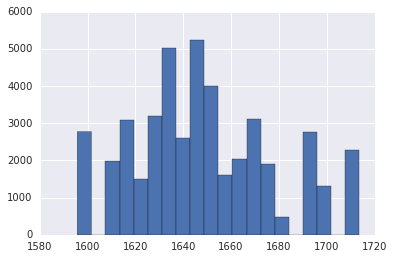

In [145]:
tmp_train.start_time.hist(bins=20)

In [121]:
'start_time' in train_date.columns

True

In [120]:
test_date.head()

,L0_S1_D26,L0_S1_D30,L0_S2_D34,L0_S2_D38,L0_S2_D42,L0_S2_D46,L0_S2_D50,L0_S2_D54,L0_S2_D58,L0_S2_D62,...,L3_S37_D3942,L3_S37_D3943,L3_S37_D3945,L3_S37_D3947,L3_S37_D3949,L3_S37_D3951,L3_S38_D3953,L3_S38_D3957,L3_S38_D3961,start_time
Id,,,,,,,,,,,,,,,,,,,,,
22,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,11.26,11.26,11.26,11.26,11.26,11.26,NaN,NaN,NaN,1699.10
69,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6.81,6.81,6.81,6.81,6.81,6.81,NaN,NaN,NaN,1653.24
74,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,2.95,2.95,2.95,2.95,2.95,2.95,NaN,NaN,NaN,1643.28
105,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.20,2.20,2.20,2.20,2.20,2.20,NaN,NaN,NaN,1625.58
195,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,0.41,0.41,0.41,0.41,0.41,NaN,NaN,NaN,1641.87
